In [1]:
import pickle
import pandas as pd
import matplotlib
import os
import re

import scipy

import collections
import datetime
import time

import geopandas as gpd

import numpy as np
 
from difflib import get_close_matches

from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from sklearn import linear_model

import statsmodels.api as sm
import statsmodels.formula.api as smf

from linearmodels import PanelOLS, FamaMacBeth
from scipy import stats

import itertools

import matplotlib.pyplot as plt

from numpy.linalg import matrix_rank

import seaborn as sns

import string

from matplotlib.transforms import Affine2D


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

In [2]:
os.getcwd()

'/Users/brianreed/Documents/supplyChain/extremes/extremesAnalysisCode'

In [67]:
tableData = pd.read_table("../../data/companyData/all_byPrecipTercile.txt",
                         header = 1, dtype = 'str').dropna(axis = 0, how = 'all')
cols = ['VARIABLES']
tableData.loc[:,cols] = tableData.loc[:,cols].ffill()
tableData['LABELS']   = tableData['LABELS'].fillna('stdErrors')

lastRow = list(tableData.VARIABLES).index('Observations')

tableData = tableData.iloc[0:lastRow,:]
for col in tableData.columns[2:]:
    tableData[col] = tableData[col].astype('str').str.replace('*', '').str.replace('(', '').str.replace(')', '').astype('float64')

tableData.head()


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


,VARIABLES,LABELS,excessrain,excessrainemp,excessrainnational,extremeprecipquarterly
1,1bn.preciptercile,"precipTercile = 1b,",-0.001300,-0.000656,-0.001130,-0.01130
2,1bn.preciptercile,stdErrors,0.000678,0.000695,0.000951,0.00617
3,2.preciptercile,precipTercile = 2,-0.000293,-0.000786,-0.000062,-0.00501
4,2.preciptercile,stdErrors,0.000504,0.000550,0.000678,0.00424
5,3.preciptercile,precipTercile = 3,-0.001700,-0.002060,-0.001920,-0.01930


In [77]:
tableData.head()

,VARIABLES,LABELS,excessrain,excessrainemp,excessrainnational,extremeprecipquarterly
1,1bn.preciptercile,"precipTercile = 1b,",-0.001300,-0.000656,-0.001130,-0.01130
2,1bn.preciptercile,stdErrors,0.000678,0.000695,0.000951,0.00617
3,2.preciptercile,precipTercile = 2,-0.000293,-0.000786,-0.000062,-0.00501
4,2.preciptercile,stdErrors,0.000504,0.000550,0.000678,0.00424
5,3.preciptercile,precipTercile = 3,-0.001700,-0.002060,-0.001920,-0.01930


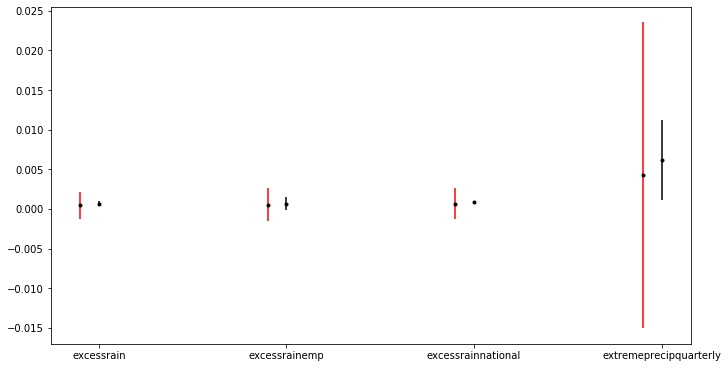

In [86]:
x   = tableData.columns[2:]

y1      = tableData.iloc[1,2:]
errors1 = tableData.iloc[2,2:]

y2      = tableData.iloc[3,2:]
errors2 = tableData.iloc[4,2:]



xdim = 10
ydim = 5
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all',
                                  figsize=(xdim,ydim),
                                  constrained_layout=True)

plt.errorbar(x,y1,yerr = errors1, fmt = '.k')

trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
plt.errorbar(x,y2,yerr = errors2, fmt = '.k', transform = trans1, ecolor = 'red')

'''ax[rowIndex, colIndex].xaxis.grid(False)
ax[rowIndex, colIndex].yaxis.grid(False)
ax[rowIndex, colIndex].axhline(y=0)
ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + yLims, yLims/2))
ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
ax[rowIndex, colIndex].set_title(ind, fontsize = 24)'''
plt.show()

# By Background Climate

In [182]:
cliData = pd.read_csv("../../data/companyData/ch3_byCli_forPlotting.csv")
cliData['VARIABLES']   = cliData['VARIABLES'].fillna('stdErrors')

# lastRow = list(tableData.VARIABLES).index('Observations')

cliData = cliData.iloc[0:,:]
for col in cliData.columns[1:]:
    cliData[col] = cliData[col].astype('str').str.replace('*', '').str.replace('(', '').str.replace(')', '').astype('float64')

cliData


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,VARIABLES,excessheat90plusemp,heatanomalydaily_wtd,excessheatemp,heatanomalyquarterly_wtd,extremeheatquarterly_wtd,excessrainemp,precipanomalydaily_wtd,precipanomaly_natl_wtd,precip95national_wtd,precipanomalyquarterly_wtd,extremeprecipquarterly_wtd
0,t1,-0.02220,0.000942,0.00452,-0.0611,0.1290,-0.0233,-0.00169,-0.00334,-0.03080,-0.0226,-0.2280
1,stdErrors,0.00681,0.003700,0.01100,0.0886,0.1280,0.0201,0.00391,0.00832,0.03120,0.0908,0.1690
2,t2,-0.01220,-0.001250,-0.00159,0.0195,0.2000,-0.0304,-0.00522,-0.01300,-0.03700,-0.0745,-0.0462
3,stdErrors,0.00416,0.004950,0.01050,0.0894,0.1580,0.0147,0.00442,0.00778,0.01990,0.0832,0.1060
4,t3,-0.00773,-0.000896,-0.00804,-0.0244,0.0617,-0.0159,-0.00637,-0.00191,-0.00398,-0.0406,-0.0976
5,stdErrors,0.00284,0.005440,0.01070,0.0926,0.1400,0.0126,0.00528,0.00756,0.01650,0.0851,0.1240


0   -0.02220
2   -0.01220
4   -0.00773
Name: excessheat90plusemp, dtype: float64 1    0.013348
3    0.008154
5    0.005566
Name: excessheat90plusemp, dtype: float64


Text(0.5, 0, 'Average Precipitation')

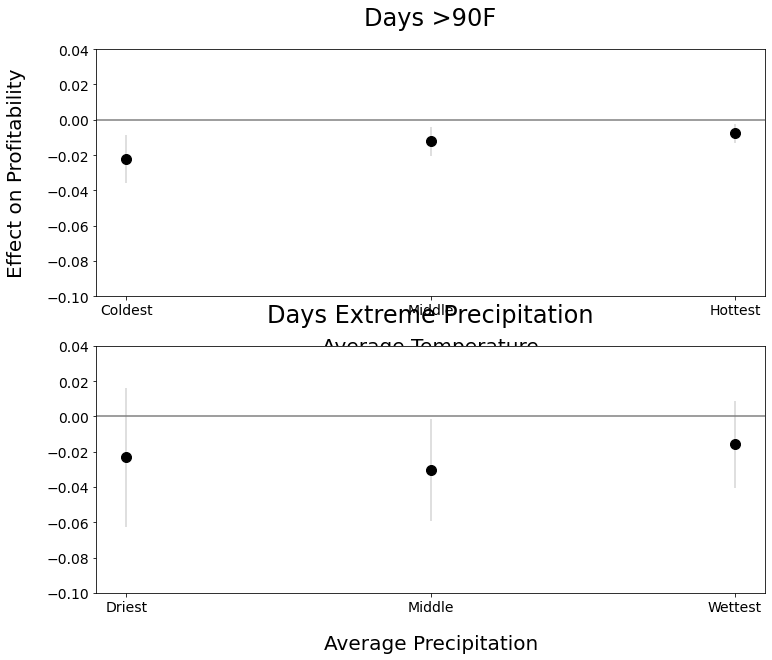

In [192]:
x_heat        = ['Coldest','Middle','Hottest']
x_precip      = ['Driest', 'Middle','Wettest']


heat          = cliData[~cliData.VARIABLES.str.contains('Error')].excessheat90plusemp
heatErrors    = cliData[cliData.VARIABLES.str.contains('Error')].excessheat90plusemp*1.96

precip        = cliData[~cliData.VARIABLES.str.contains('Error')].excessrainemp
precipErrors  = cliData[cliData.VARIABLES.str.contains('Error')].excessrainemp*1.96



print(heat,heatErrors)


xdim = 12
ydim = 10

fig, ax = plt.subplots(2, 1,  sharey='all',
                                  figsize=(xdim,ydim))
# fig.suptitle("Results by Background Climate",fontsize = 28, y = 1.1)
plt.rcParams.update({'font.size': 14})


plt.subplot(2,1,1)
plt.errorbar(x_heat, heat, yerr = heatErrors, fmt ='.k',elinewidth=0.25,markersize = '20')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
# plt.box(False)
plt.title("Days >90F",fontsize = 24, pad=24)
plt.xlabel("Average Temperature", fontsize = 20, labelpad=20)
plt.ylabel("Effect on Profitability", fontsize = 20, labelpad=20)
# plt.rcParams['axes.labelsize'] = 48

plt.subplot(2,1,2)
plt.errorbar(x_precip, precip, yerr = precipErrors, fmt ='.k',elinewidth=0.25,markersize = '20')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
plt.axis(ymin = -0.1, ymax = 0.04)
plt.title("Days Extreme Precipitation",fontsize = 24, pad=24)
plt.xlabel("Average Precipitation", fontsize = 20, labelpad=20)
# plt.box(False)


# By Quarter

In [12]:
qtrData = pd.read_csv("../../data/companyData/ch3_qtr_forPlotting.csv")
qtrData['VARIABLES']   = qtrData['VARIABLES'].fillna('stdErrors')

# lastRow = list(tableData.VARIABLES).index('Observations')

qtrData = qtrData.iloc[0:,:]
for col in qtrData.columns[1:]:
    qtrData[col] = qtrData[col].astype('str').str.replace('*', '').str.replace('(', '').str.replace(')', '').astype('float64')

qtrData


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,VARIABLES,excessheat90plusemp,excessrainemp
0,"qtr = 1b,",-0.04280,-0.01890
1,stdErrors,0.02800,0.01380
2,qtr = 2,-0.01270,-0.00592
3,stdErrors,0.00739,0.01350
4,qtr = 3,-0.00686,-0.02690
5,stdErrors,0.00295,0.01090
6,qtr = 4,-0.01530,-0.02050
7,stdErrors,0.00410,0.01610


0   -0.04280
2   -0.01270
4   -0.00686
6   -0.01530
Name: excessheat90plusemp, dtype: float64 1    0.054880
3    0.014484
5    0.005782
7    0.008036
Name: excessheat90plusemp, dtype: float64


"y1      = qtrData.iloc[0,1:]\nerrors1 = qtrData.iloc[1,1:]*1.96\n\ny2      = qtrData.iloc[2,1:]\nerrors2 = qtrData.iloc[3,1:]*1.96\n\ny3      = qtrData.iloc[4,1:]\nerrors3 = qtrData.iloc[5,1:]*1.96\n\ny4      = qtrData.iloc[6,1:]\nerrors4 = qtrData.iloc[7,1:]*1.96\n\n\n\n\n###### plot 1\nplt.errorbar(x,y1,yerr = errors1, fmt = '.k')\n\ntrans1 = Affine2D().translate(0.1, 0.0) + ax.transData\nplt.errorbar(x,y2,yerr = errors2, fmt = '.k', transform = trans1)\n\ntrans2 = Affine2D().translate(0.2, 0.0) + ax.transData\nplt.errorbar(x,y3,yerr = errors3, fmt = '.k', transform = trans2)\n\ntrans3 = Affine2D().translate(0.3, 0.0) + ax.transData\nplt.errorbar(x,y4,yerr = errors4, fmt = '.k', transform = trans3)\n\nplt.axhline(y = 0, color = 'gray', linestyle = '-')"

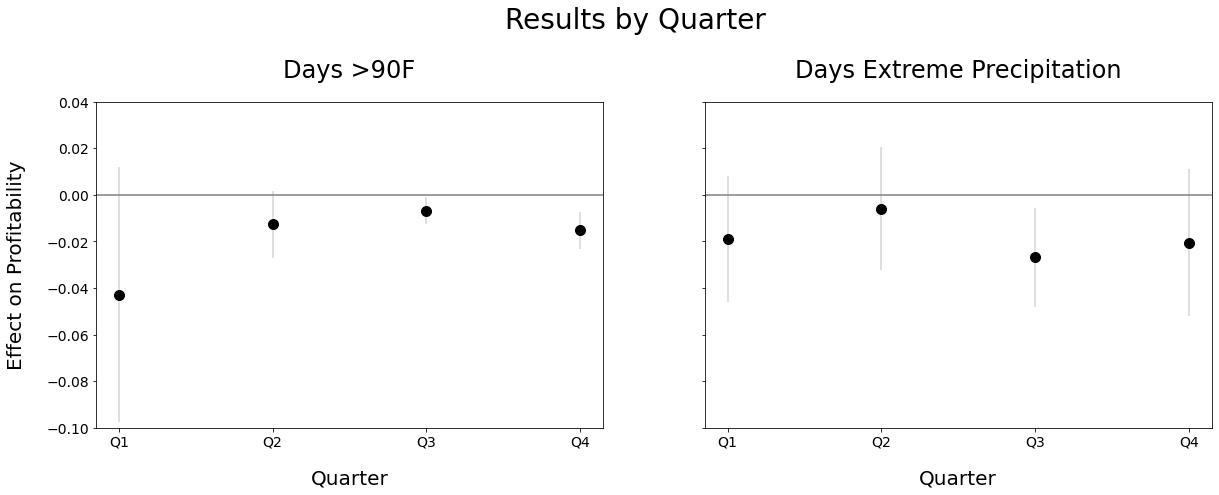

In [174]:
x       = ['Q1','Q2','Q3','Q4']


heat          = qtrData[~qtrData.VARIABLES.str.contains('Error')].excessheat90plusemp
heatErrors    = qtrData[qtrData.VARIABLES.str.contains('Error')].excessheat90plusemp*1.96

precip        = qtrData[~qtrData.VARIABLES.str.contains('Error')].excessrainemp
precipErrors  = qtrData[qtrData.VARIABLES.str.contains('Error')].excessrainemp*1.96



print(heat,heatErrors)


xdim = 20
ydim = 6

fig, ax = plt.subplots(1, 2,  sharey='all',
                                  figsize=(xdim,ydim))
fig.suptitle("Results by Quarter",fontsize = 28, y = 1.1)
plt.rcParams.update({'font.size': 14})


plt.subplot(1,2,1)
plt.errorbar(x, heat, yerr = heatErrors, fmt ='.k',elinewidth=0.25,markersize = '20')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
# plt.box(False)
plt.title("Days >90F",fontsize = 24, pad=24)
plt.xlabel("Quarter", fontsize = 20, labelpad=20)
plt.ylabel("Effect on Profitability", fontsize = 20, labelpad=20)
# plt.rcParams['axes.labelsize'] = 48

plt.subplot(1,2,2)
plt.errorbar(x, precip, yerr = precipErrors, fmt ='.k',elinewidth=0.25,markersize = '20')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
plt.axis(ymin = -0.1, ymax = 0.04)
plt.title("Days Extreme Precipitation",fontsize = 24, pad=24)
plt.xlabel("Quarter", fontsize = 20, labelpad=20)
# plt.box(False)


# By Industry

In [175]:
indData = pd.read_csv("../../data/companyData/ch3_ind_forPlotting.csv")
indData['VARIABLES']   = indData['VARIABLES'].fillna('stdErrors')

# lastRow = list(tableData.VARIABLES).index('Observations')

indData = indData.iloc[0:,:]
for col in indData.columns[1:]:
    indData[col] = indData[col].astype('str').str.replace('*', '').str.replace('(', '').str.replace(')', '').astype('float64')

indData


/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,VARIABLES,excessheat90plusemp,excessrainemp,heatanomalydaily_wtd,excessheatemp,precipanomalydaily_wtd,precipanomaly_natl_wtd,precip95national_wtd,heatanomalyquarterly_wtd,extremeheatquarterly_wtd,precipanomalyquarterly_wtd,extremeprecipquarterly_wtd
0,"gsectorDesc = 1b,",-0.00466,0.012400,-0.002720,-0.01150,0.007860,0.009600,0.01380,-0.0533,0.1110,-0.07080,-0.0929
1,stdErrors,0.00578,0.017000,0.005730,0.01050,0.008400,0.011300,0.02160,0.1300,0.1500,0.08480,0.1340
2,"gsectorDesc = 2, Consumer Staples",0.00576,-0.059100,0.008530,0.01790,-0.027100,-0.025800,-0.06080,0.2100,0.3510,-0.51400,-0.3220
3,stdErrors,0.00841,0.038100,0.010500,0.03890,0.010500,0.018000,0.05220,0.1710,0.4720,0.24500,0.4050
4,"gsectorDesc = 3, Energy",-0.00190,-0.047200,-0.006430,0.00571,0.001020,0.001100,-0.06740,-0.1820,0.0728,-0.21900,-0.6100
5,stdErrors,0.00471,0.015100,0.005790,0.00859,0.005740,0.008830,0.02120,0.1210,0.1610,0.14200,0.1740
6,"gsectorDesc = 4, Health Care",-0.02360,-0.006350,0.007280,-0.04690,-0.012600,-0.000329,-0.00788,0.0530,0.3740,-0.00662,0.3670
7,stdErrors,0.01050,0.028700,0.008820,0.02600,0.008370,0.013400,0.03700,0.1630,0.2540,0.17000,0.3070
8,"gsectorDesc = 5, Industrials",-0.01150,-0.045500,0.000636,0.00852,-0.010300,-0.024400,-0.04390,0.1000,-0.0190,-0.03520,-0.1910
9,stdErrors,0.00625,0.020700,0.005150,0.01130,0.006730,0.011400,0.02760,0.1030,0.1940,0.10200,0.1300


0    -0.00466
2     0.00576
4    -0.00190
6    -0.02360
8    -0.01150
10   -0.00510
12   -0.02270
14    0.00355
Name: excessheat90plusemp, dtype: float64 1     0.011329
3     0.016484
5     0.009232
7     0.020580
9     0.012250
11    0.009290
13    0.023324
15    0.009839
Name: excessheat90plusemp, dtype: float64


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

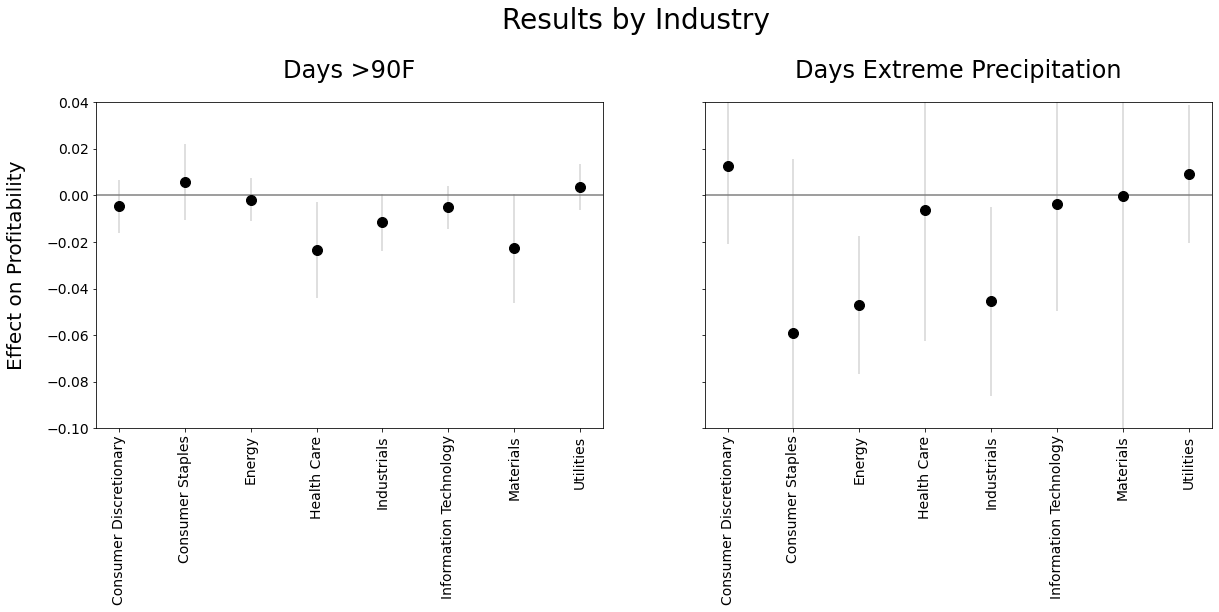

In [181]:
x       = ['Consumer Discretionary','Consumer Staples','Energy','Health Care',
          'Industrials','Information Technology','Materials','Utilities']


heat          = indData[~indData.VARIABLES.str.contains('Error')].excessheat90plusemp
heatErrors    = indData[indData.VARIABLES.str.contains('Error')].excessheat90plusemp*1.96

precip        = indData[~indData.VARIABLES.str.contains('Error')].excessrainemp
precipErrors  = indData[indData.VARIABLES.str.contains('Error')].excessrainemp*1.96



print(heat,heatErrors)


xdim = 20
ydim = 6

fig, ax = plt.subplots(1, 2,  sharey='all',
                                  figsize=(xdim,ydim))
fig.suptitle("Results by Industry",fontsize = 28, y = 1.1)
plt.rcParams.update({'font.size': 14})


plt.subplot(1,2,1)
plt.errorbar(x, heat, yerr = heatErrors, fmt ='.k',elinewidth=0.25,markersize = '20')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
# plt.box(False)
plt.title("Days >90F",fontsize = 24, pad=24)
# plt.xlabel("Quarter", fontsize = 20, labelpad=20)
plt.ylabel("Effect on Profitability", fontsize = 20, labelpad=20)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

# plt.rcParams['axes.labelsize'] = 48

plt.subplot(1,2,2)
plt.errorbar(x, precip, yerr = precipErrors, fmt ='.k',elinewidth=0.25,markersize = '20')
plt.axhline(y = 0, color = 'gray', linestyle = '-')
plt.axis(ymin = -0.1, ymax = 0.04)
plt.title("Days Extreme Precipitation",fontsize = 24, pad=24)
# plt.xlabel("Quarter", fontsize = 20, labelpad=20)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

# plt.box(False)


In [153]:
def makePlots(results, industries, filePrefix, yLim, numCol = 2, padding = 1, xdim = 20, ydim = 40):
    
    # loop over outcome variables and weather definitions
    weatherVars = results.weatherVar.unique()
    outcomeVars = results.outcomeVar.unique()


    for outcome in outcomeVars:
        for weather in weatherVars:
            # choose the elective parts of this - number of columns and the range of the axes
            numCols = numCol
            yLims   = yLim

            rowNum = len(industries) // numCols + padding
            colNum = numCols

            fig, ax = plt.subplots(rowNum, colNum, sharex='all', sharey='all',
                                  figsize=(xdim,ydim),
                                  constrained_layout=True)

            fig.suptitle('Direct Effects: ' + outcome + ' ~ ' + weather, fontsize=36)



            i = 0
            for ind in industries:
                rowIndex = i // numCols 
                colIndex = i % numCols


                i   = i + 1


                rev = results[(results.outcomeVar == outcome) & (results.weatherVar == weather) & 
                             (results.industry == ind)].reset_index()
                # indName = rev.industryName.unique()[0]
                x   = [0,1,2,3,4]
                y   = [rev.lag0,rev.lag1,rev.lag2,rev.lag3,rev.lag4]


                errors = [rev.bse0,rev.bse1,rev.bse2,rev.bse3,rev.bse4]


                ax[rowIndex, colIndex].errorbar(x,y,yerr = errors, fmt = '.k')
                ax[rowIndex, colIndex].xaxis.grid(False)
                ax[rowIndex, colIndex].yaxis.grid(False)
                ax[rowIndex, colIndex].axhline(y=0)
                ax[rowIndex, colIndex].set_ylim([-yLims, yLims])

                ax[rowIndex, colIndex].yaxis.set_ticks(np.arange(-yLims, yLims + yLims, yLims/2))
                ax[rowIndex, colIndex].xaxis.set_ticks(np.arange(0.0, 5.0, 1.0))

                ax[rowIndex, colIndex].tick_params(axis='both', labelsize = 16)
                ax[rowIndex, colIndex].set_title(ind, fontsize = 24)

            fig.savefig(filePrefix + outcome + weather + '.png')
            fig.show()


                # ax[rowIndex, colIndex].



